
# **Do neighborhoods with higher income correlate to higher crime rates?**

# Data gathering

In [ ]:
#All finalised needed imports
import pandas as pd
import itertools
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import warnings
import seaborn as sns
from scipy.stats import zscore
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Suppress warnings
warnings.filterwarnings("ignore")

# this assumes you have downloaded the training dataset to the My Drive/Colab Notebooks folder.
# gets the income data set and the arrests data set, the two data sets that are used in the report
from google.colab import drive
drive.mount('/content/drive')
df_income = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Neighborhood_Income.csv')
df_arrests = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tucson_Police_Arrests.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing

In [ ]:
# NOTE: Working only on the 2019 datasets as our neighborhood_income.csv file only has 2019 data

############# CLEAN THE ARREST DATA BASE #############

# 1) drop the arrests that have no associated neighborhood
df_arrests_cleaned = df_arrests.dropna(subset=['NHA_NAME'])

# 2) only include charge description and NHA_NAME
df_arrests_cleaned = df_arrests_cleaned[['chrgdesc', 'NHA_NAME']]

############# CLEAN THE INCOME DATA BASE #############

# 1) rename 'NAME' to 'NHA_NAME' to match the other data set
df_income.rename(columns={'NAME': 'NHA_NAME'}, inplace=True)

# 2) only include the relevant columns
df_income_cleaned = df_income[['NHA_NAME', 'WLTHINDXCY', 'TOTHH_CY', 'PCI_CY', 'MEDHINC_CY']]

# 3) Count the number of arrests per neighborhood
num_arrests = df_arrests_cleaned.groupby('NHA_NAME').size().reset_index(name='num_arrests')

# 4) Include the arrests per neighborhood in the df_income_cleaned data base
df_income_cleaned = pd.merge(num_arrests, df_income_cleaned, on='NHA_NAME')

# 5) Calculate the ratio of arrests to households and include in df_income_cleaned data base
df_income_cleaned['arrests_per_household'] = df_income_cleaned['num_arrests'] / df_income_cleaned['TOTHH_CY']

############# CREATE A MERGED DATA BASE #############
df_merged_original = pd.merge(df_income_cleaned, df_arrests_cleaned, on='NHA_NAME')
df_merged_original.head()

,NHA_NAME,num_arrests,WLTHINDXCY,TOTHH_CY,PCI_CY,MEDHINC_CY,arrests_per_household,chrgdesc
0,A Mountain,202,32,1103,15189,39293,0.183137,DISORDERLY CONDUCT-DISTURBING THE PEACE-DV REL...
1,A Mountain,202,32,1103,15189,39293,0.183137,DRUG PARAPHERNALIA-POSSESS/USE ...
2,A Mountain,202,32,1103,15189,39293,0.183137,NARCOTIC DRUG-ILLEGALLY POSSESS/USE/SELL/TRANS...
3,A Mountain,202,32,1103,15189,39293,0.183137,MARIJUANA-POSSESS/USE ...
4,A Mountain,202,32,1103,15189,39293,0.183137,MARIJUANA-POSSESS/SELL/USE/TRANSPORT (CRIM) ...


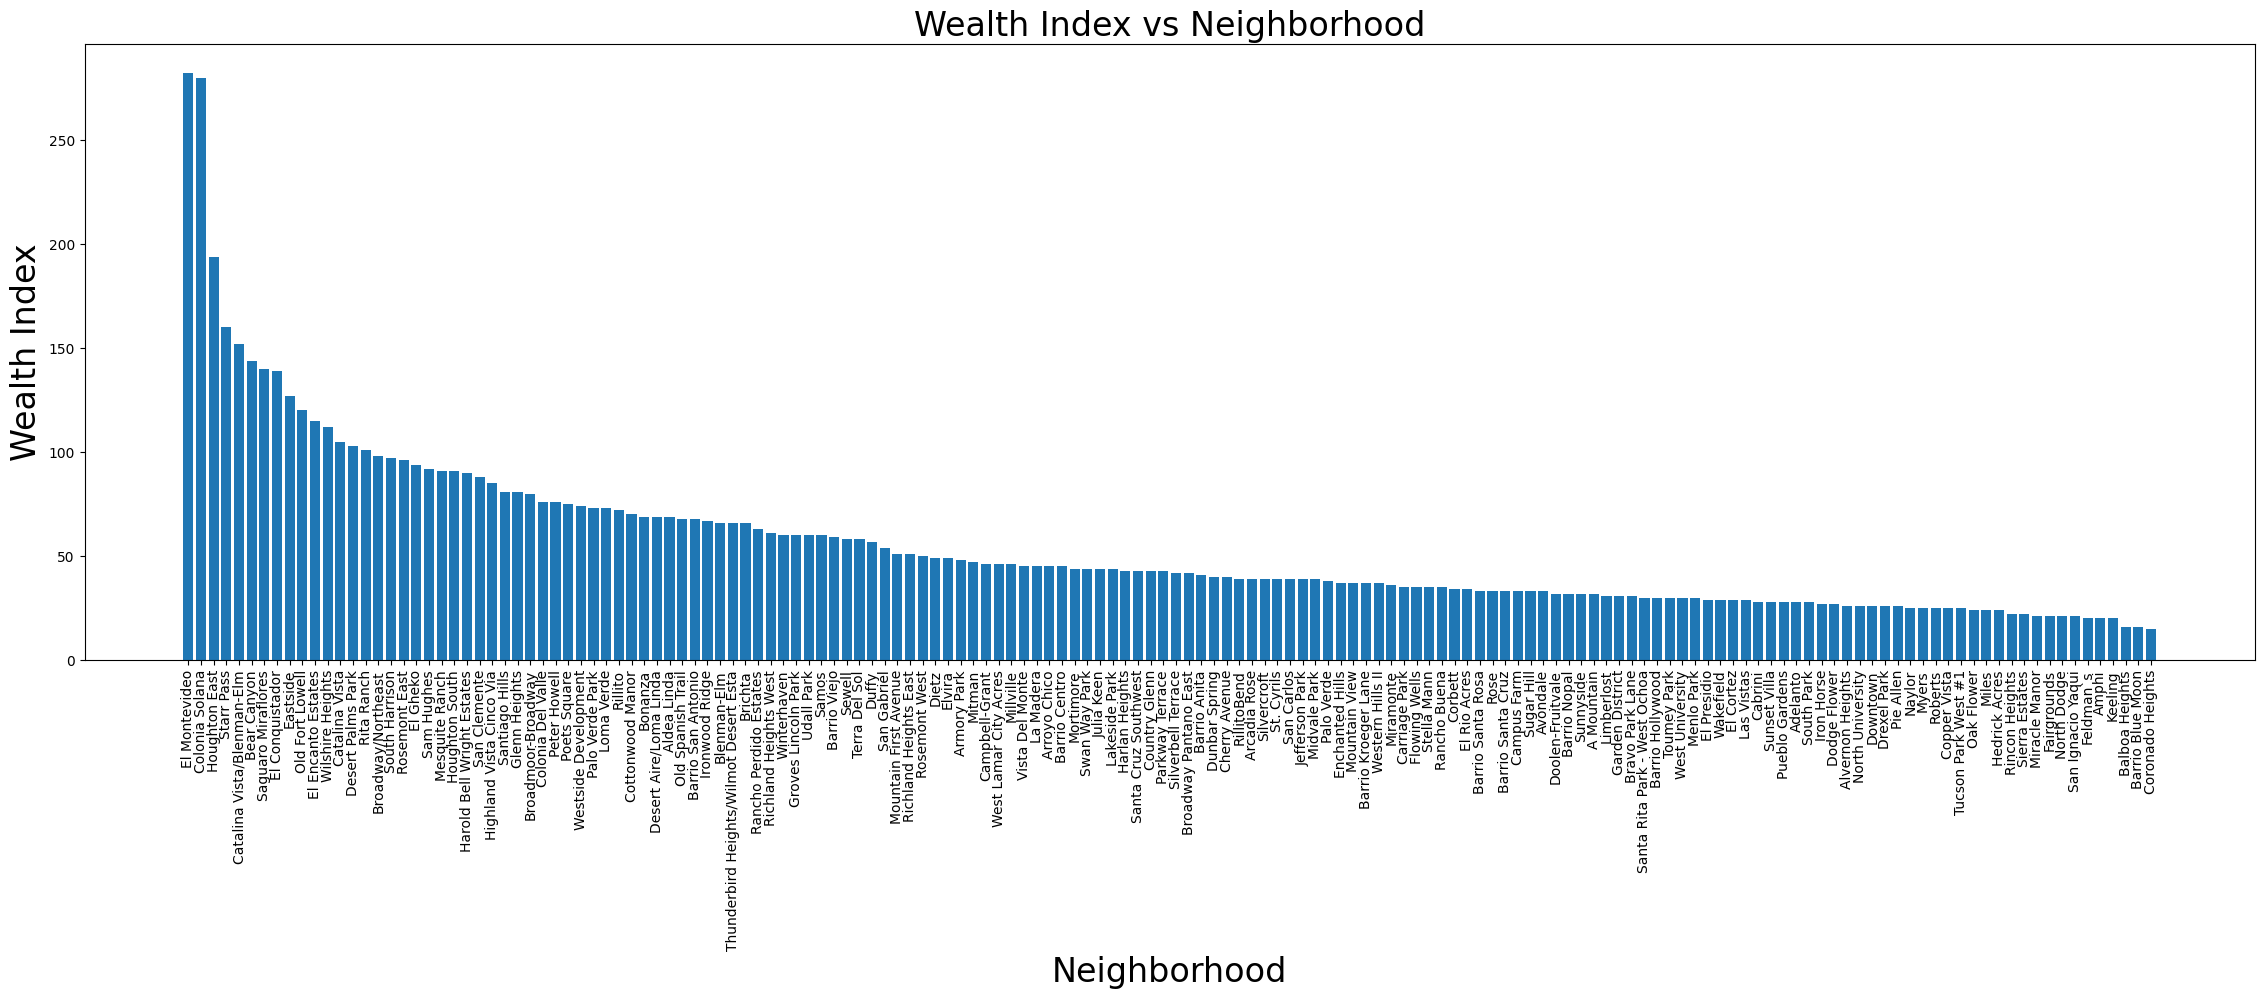

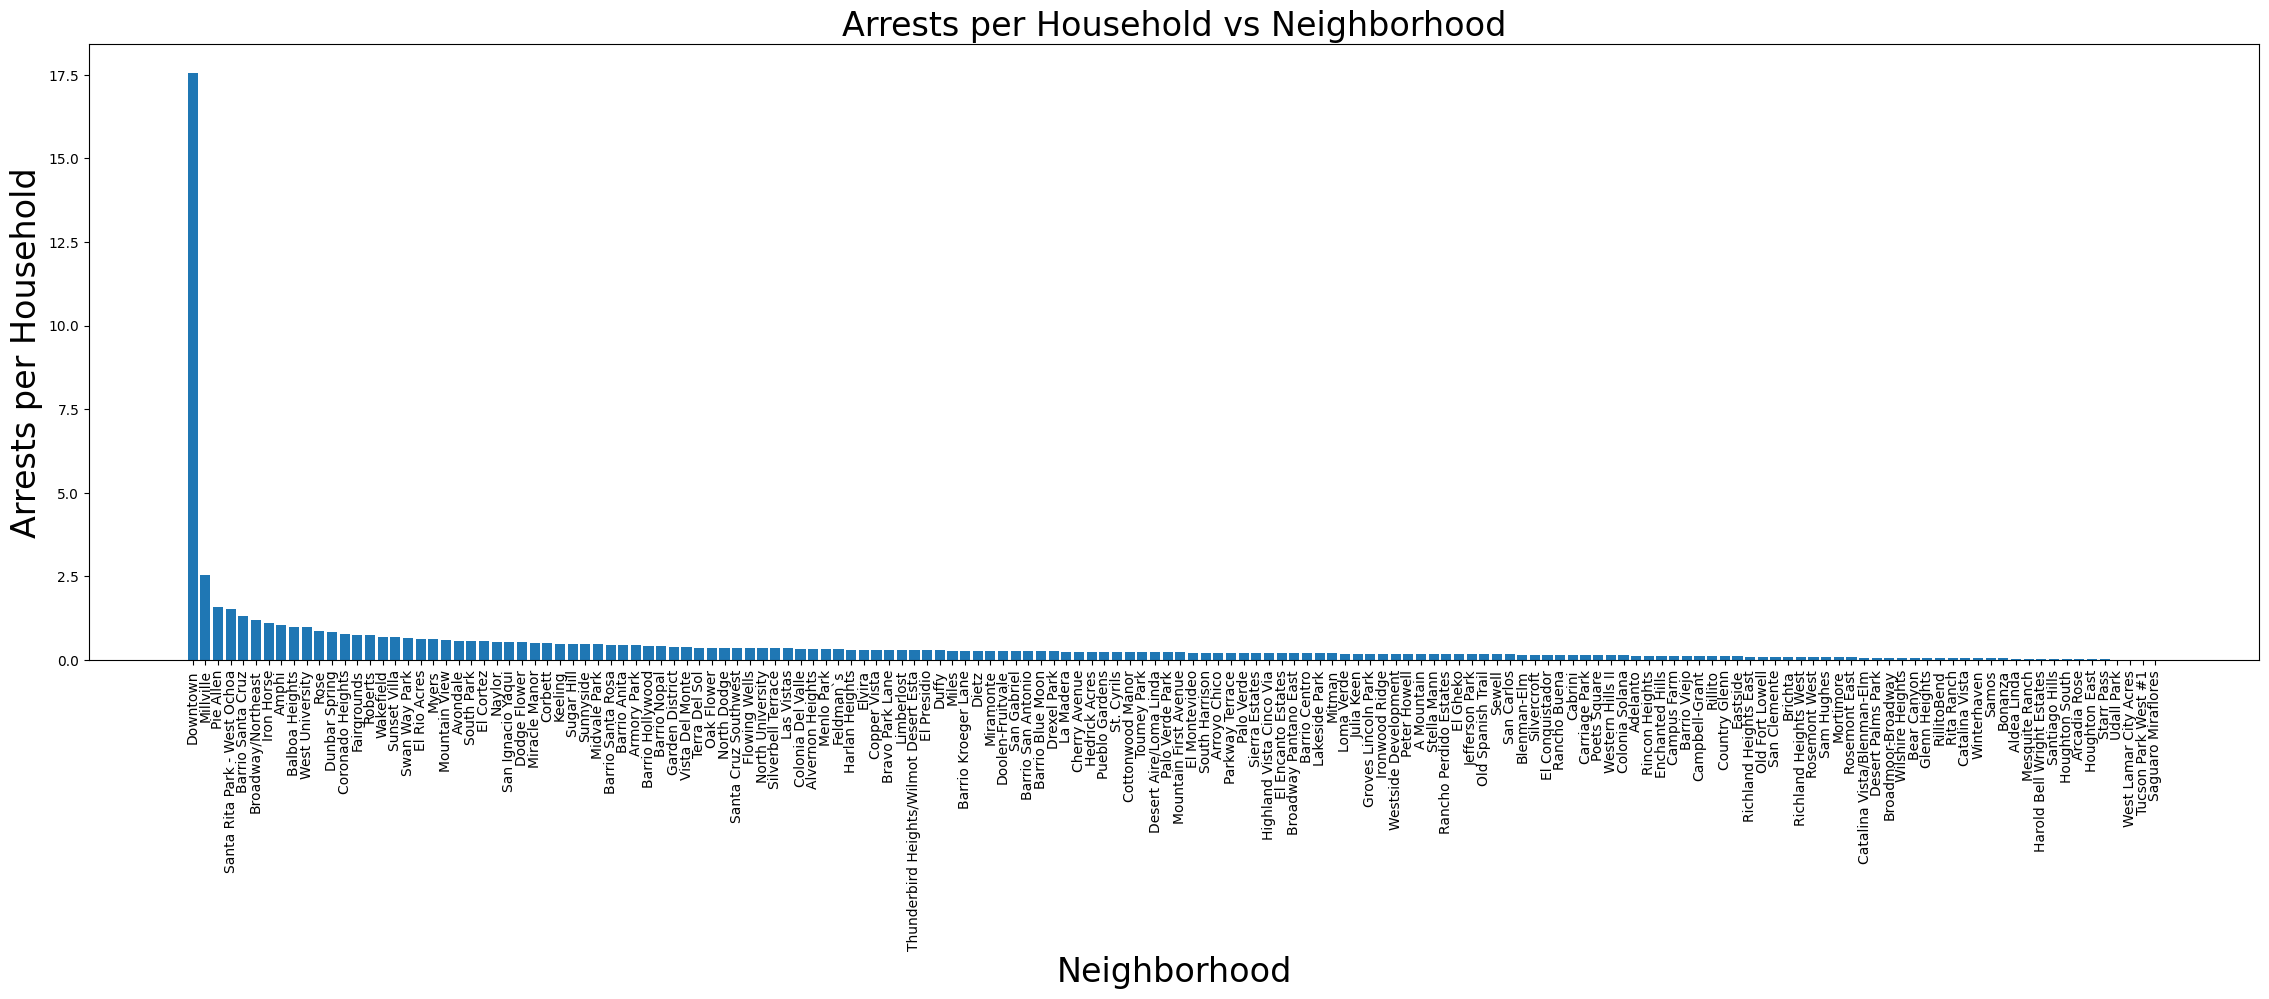

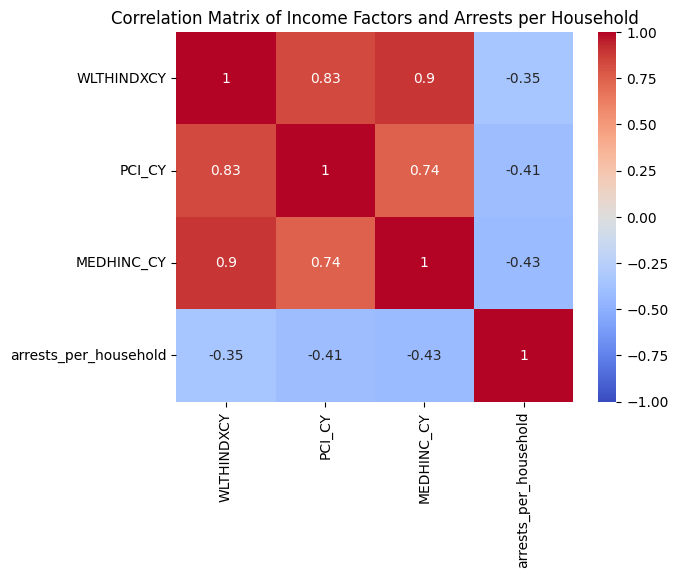

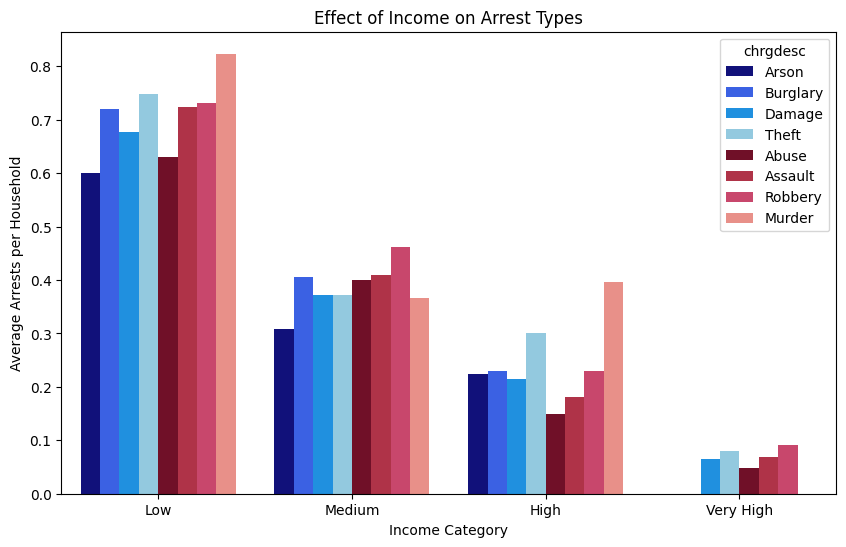

Low: $0.00 - $29,000.00
Medium: $29,000.00 - $58,000.00
High: $58,000.00 - $87,000.00
Very High: $87,000.00 - $116,000.00


In [ ]:
################################################################################
################## Plot 1: Wealth Index vs Neighborhood ########################
################################################################################
# Sort
df_income_cleaned = df_income_cleaned.sort_values(by='WLTHINDXCY', ascending = False)

plt.figure(figsize=(28,8))
plt.bar(df_income_cleaned['NHA_NAME'], df_income_cleaned['WLTHINDXCY'])
plt.xlabel('Neighborhood', fontsize=24)
plt.ylabel('Wealth Index', fontsize=24)
plt.title('Wealth Index vs Neighborhood', fontsize=24)
plt.xticks(rotation=90)
plt.show()

# Reset the sort
df_income_cleaned = df_income_cleaned.sort_values(by='WLTHINDXCY', ascending=False).reset_index(drop=True)



############ Plot 2: Arrests per Household vs Neighborhood #############
# Sort
df_merged_original = df_merged_original.sort_values(by='arrests_per_household', ascending=False)

plt.figure(figsize=(28, 8))
plt.bar(df_merged_original['NHA_NAME'], df_merged_original['arrests_per_household'])
plt.xlabel('Neighborhood', fontsize=24)
plt.ylabel('Arrests per Household', fontsize=24)
plt.title('Arrests per Household vs Neighborhood', fontsize=24)
plt.xticks(rotation=90)
plt.show()

# Reset the sort
df_merged_original = df_merged_original.sort_values(by='arrests_per_household', ascending=False).reset_index(drop=True)



################################################################################
############# Plot 3: Arrests per Household vs Income Factors Heat Map #########
################################################################################
df_merged_original = df_merged_original[df_merged_original['NHA_NAME'] != 'Downtown']

corr = df_merged_original[['WLTHINDXCY', 'PCI_CY', 'MEDHINC_CY', 'arrests_per_household']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Income Factors and Arrests per Household")
plt.show()



################################################################################
############# Plot 4: Arrests per Household vs Different Types of Crime ########
################################################################################

# Downtown neighborhood was an extreme outlier that even log-based distribution was unable to smooth out. As a result, we decided to remove it as we considered it would bring more noise.
df_merged = df_merged_original.copy()
df_merged = df_merged[df_merged['NHA_NAME'] != 'Downtown']

# making the descriptions more uniform
df_merged['chrgdesc'] = df_merged['chrgdesc'].str.replace(r'(?i).*theft.*', 'Theft', regex=True)
df_merged['chrgdesc'] = df_merged['chrgdesc'].str.replace(r'(?i).*robbery.*', 'Robbery', regex=True)
df_merged['chrgdesc'] = df_merged['chrgdesc'].str.replace(r'(?i).*burglary.*', 'Burglary', regex=True)
df_merged['chrgdesc'] = df_merged['chrgdesc'].str.replace(r'(?i).*criminal damage.*', 'Damage', regex=True)
df_merged['chrgdesc'] = df_merged['chrgdesc'].str.replace(r'(?i).*abuse.*', 'Abuse', regex=True)
df_merged['chrgdesc'] = df_merged['chrgdesc'].str.replace(r'(?i).*murder.*', 'Murder', regex=True)
df_merged['chrgdesc'] = df_merged['chrgdesc'].str.replace(r'(?i).*assault.*', 'Assault', regex=True)
df_merged['chrgdesc'] = df_merged['chrgdesc'].str.replace(r'(?i).*arson.*', 'Arson', regex=True)

# only including these crimes
df_merged = df_merged[df_merged['chrgdesc'].isin(['Theft', 'Robbery', 'Burglary', 'Damage',
                                                  'Abuse', 'Murder', 'Assault', 'Arson'])]

# creating a color pallete for the graph
# property crimes are blue, violent are red
custom_palette = {
    'Theft': '#87CEEB',
    'Burglary': '#1F51FF',
    'Arson': '#00008B',
    'Damage': '#0096FF',
    'Robbery': '#DE3163',
    'Abuse': '#800020',
    'Murder': '#F88379',
    'Assault': '#C41E3A'
}

# creating better visual order for the graph
arrest_order = ["Arson", "Burglary", "Damage", "Theft", "Abuse", "Assault", "Robbery", "Murder"]

# Group by income category and crime type, then calculate mean arrests
bins = [0, 29000, 58000, 87000, 116000]
labels = ["Low", "Medium", "High", "Very High"]

# Categorize income using pd.cut
df_merged['income_category'] = pd.cut(
    df_merged['MEDHINC_CY'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
grouped = df_merged.groupby(['income_category', 'chrgdesc'])['arrests_per_household'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped, x="income_category", y="arrests_per_household", hue="chrgdesc", palette=custom_palette, hue_order=arrest_order)
plt.title("Effect of Income on Arrest Types")
plt.ylabel("Average Arrests per Household")
plt.xlabel("Income Category")
plt.show()

# Print the bin ranges for the income categories
for i in range(len(bins) - 1):
    print(f"{['Low', 'Medium', 'High', 'Very High'][i]}: ${bins[i]:,.2f} - ${bins[i+1]:,.2f}")


# Revise question/hypothesis, state the prediction/classification task

**Model 1: Linear/Polynomial Regression**

**Hypothesis: Can we predict the number of arrests per household when given income data?**

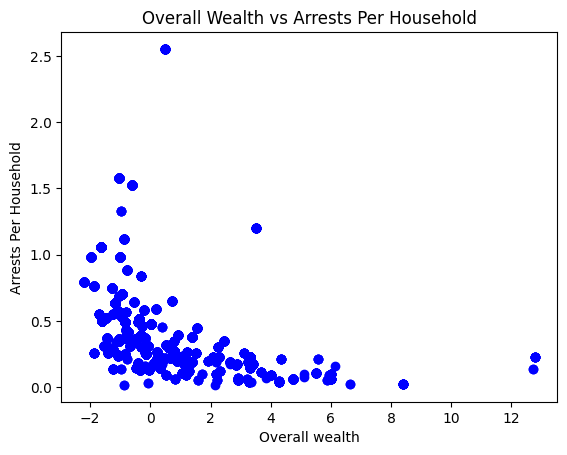

In [ ]:
################################################################################
## CAN WE PREDICT THE NUMBER OF ARRESTS PER HOUSEHOLD WHEN GIVEN INCOME DATA? ##
################################################################################

# Some context, ['WLTHINDXCY', 'PCI_CY', 'MEDHINC_CY'] are all highly correlated to each other
# Better to combine them into a single variable to get a better picture

# the three income variables
features = ['WLTHINDXCY', 'PCI_CY', 'MEDHINC_CY']

# what we are trying to predict
target_for_hypo1 = 'arrests_per_household'

copy_of_df = df_merged.copy(deep=True)

# standardize the data
scaler = StandardScaler()
scaler.fit_transform(copy_of_df[features])

copy_of_df[features] = scaler.transform(copy_of_df[features])

# Create a PCA object
pca = PCA(n_components=1)

# Fit and transform the correlated features
new_feature = pca.fit_transform(copy_of_df[features])

# Add the new feature to the dataframe
copy_of_df['combined_feature'] = new_feature

X1 = copy_of_df['combined_feature']  # Contains all the three features in one single variable for better interpretation of data
y1 = copy_of_df[target_for_hypo1]  # Target variable (output)

# Plot an initial scatterplot to see what we are dealing with in terms of correlation
plt.figure()
plt.scatter(X1, y1, color='blue', label='Data points')
plt.xlabel('Overall wealth')
plt.ylabel('Arrests Per Household')
plt.title("Overall Wealth vs Arrests Per Household")
plt.show()

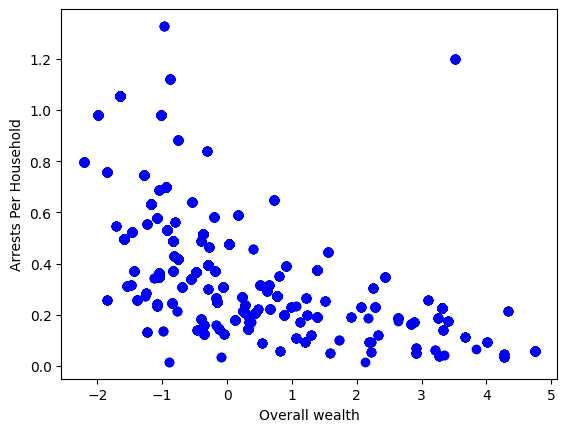

In [ ]:
# Dataset had some extreme outliers which might influence final model, so we try to remove some of them using z-score
x = X1.values.reshape(-1, 1)
y = y1
# Combine x and y into a single DataFrame
data = pd.DataFrame({'x': x.flatten(), 'y': y})

# Compute Z-scores
z_scores = np.abs(zscore(data))

# Filter rows with Z-scores below the threshold (e.g., 3)
filtered_data = data[(z_scores < 3).all(axis=1)]

# Extract cleaned x and y
x_clean = filtered_data['x'].values.reshape(-1, 1)
y_clean = filtered_data['y'].values

plt.figure()
plt.scatter(x_clean, y_clean, color='blue', label='Data points')
plt.xlabel('Overall wealth')
plt.ylabel('Arrests Per Household')
plt.show()

R2 score:  0.3256218066857244


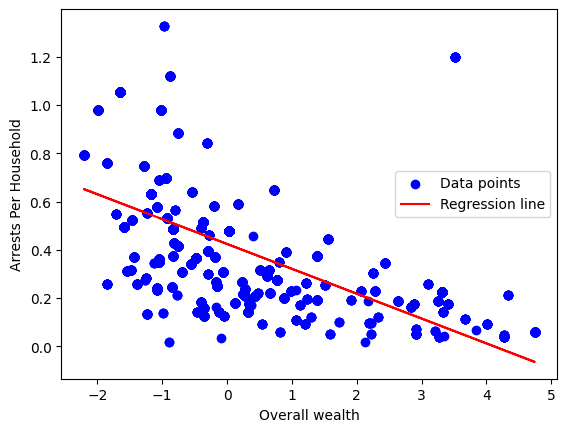

The equation of the regression line is: y = -0.10x + 0.42


In [ ]:
################################################################################
################ NOW, WE CAN APPLY LINEAR REGRESSION (MODEL 1)##################
################################################################################

# Split the data into training and testing sets (80% for training, 20% for testing)
X1_train, X1_test, y1_train, y1_test = train_test_split(x_clean, y_clean, test_size=0.2, random_state=42)

## NOTE: From here onwards we are only working with clean data
x = X1_train
y = y1_train

# See how our model looks for an initial linear regression model
lr = linear_model.LinearRegression()
lr.fit(X1_train, y1_train)

# Regression line based on the training split
y_pred = lr.predict(X1_train)

# Plot the data points and training regression line
plt.figure()
plt.scatter(X1_train, y1_train, color='blue', label='Data points')
plt.plot(X1_train, y_pred, color='red', label='Regression line')  # Add regression line
plt.xlabel('Overall wealth')
plt.ylabel('Arrests Per Household')

# Calculate and annotate R² score
r2 = lr.score(X1_train, y1_train)
print("R2 score: ", r2)

# Add legend and show the plot
plt.legend()
plt.show()

slope = lr.coef_[0]
intercept = lr.intercept_

# Print the equation of the regression line
print(f"The equation of the regression line is: y = {slope:.2f}x + {intercept:.2f}")

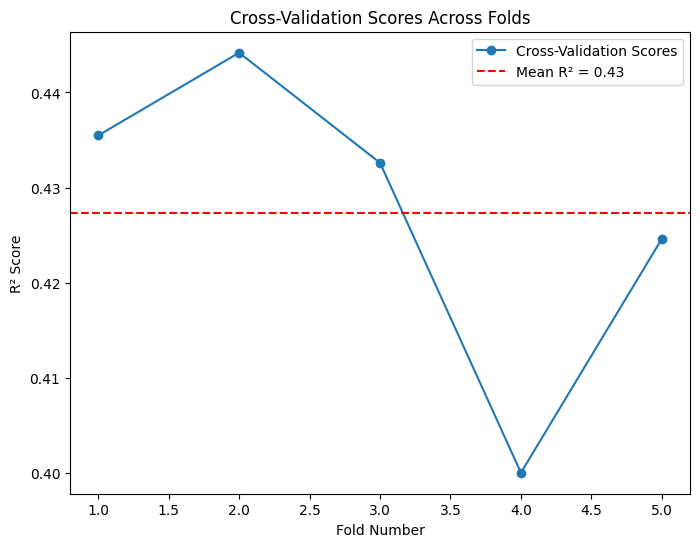

Polynomial Model CV R^2: 0.42737275940116765


In [ ]:
# Linear regression does not seem to be the best fit. Scatterplots seem more suited to a curve
# Hence, try cross validation with a polynomial fit of degree 2
poly = PolynomialFeatures(degree=2)

poly_model = make_pipeline(poly, linear_model.LinearRegression())
poly_scores = cross_val_score(poly_model, X1_train, y1_train, cv=5, scoring='r2')

# Plot the scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(poly_scores) + 1), poly_scores, marker='o', linestyle='-', label='Cross-Validation Scores')
plt.axhline(y=np.mean(poly_scores), color='r', linestyle='--', label=f'Mean R² = {np.mean(poly_scores):.2f}')
plt.xlabel('Fold Number')
plt.ylabel('R² Score')
plt.title('Cross-Validation Scores Across Folds')
plt.legend()
plt.show()

print("Polynomial Model CV R^2:", np.mean(poly_scores))

R2 score:  0.4281498996400236


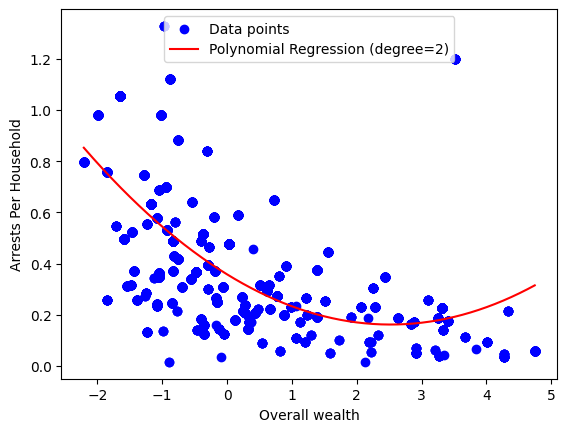

Equation of the regression line is: y = 0.3579 - 0.1556 * x^1 + 0.0309 * x^2 


In [ ]:
# Try a polynomial fit and see if the R2 score is better with the same feature
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(X1_train)


lr_poly = linear_model.LinearRegression()
lr_poly.fit(x_poly, y1_train)

# Predictions for the regression curve
y_pred = lr_poly.predict(x_poly)

# Calculate R² score
r2 = r2_score(y1_train, y_pred)

# Extract valuable information
intercept = lr_poly.intercept_  # Intercept (b0)
coefficients = lr_poly.coef_  # Coefficients (for x, x², etc.)

# Plot the data points and regression curve
plt.figure()
plt.scatter(X1_train, y1_train, color='blue', label='Data points')

# To plot a smooth curve, use a dense range of x values
x_range = np.linspace(X1_train.min(), X1_train.max(), 500).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_range_pred = lr_poly.predict(x_range_poly)

plt.plot(x_range, y_range_pred, color='red', label=f'Polynomial Regression (degree={2})')
plt.xlabel('Overall wealth')
plt.ylabel('Arrests Per Household')
print("R2 score: ", r2)

intercept = lr_poly.intercept_  # Intercept (b0)
coefficients = lr_poly.coef_  # Coefficients (for x, x², etc.)

# Construct the polynomial equation as a string
equation = f"y = {intercept:.4f} "
for i in range(1, len(coefficients)):
    if coefficients[i] >= 0:
        equation += f"+ {coefficients[i]:.4f} * x^{i} "
    else:
        equation += f"- {abs(coefficients[i]):.4f} * x^{i} "

# Add legend and show plot
plt.legend()
plt.show()

print(f"Equation of the regression line is: {equation}")

Mean Squared Error on Test Set: 0.04516467569043462
R^2 Score on Test Set: 0.3522051271174287


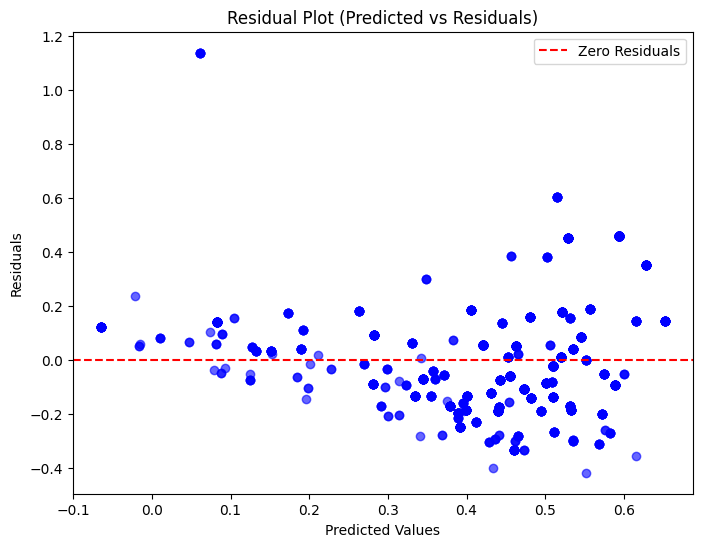

In [ ]:
# We are certain that a polynomial model is better at training our model, hence we will start evaluating it against our testing dataset
# EVALUATE MODEL ON TEST SPLIT
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(X1_train)
x_test_poly = poly.fit_transform(X1_test)

ols_model = linear_model.LinearRegression().fit(X1_train, y1_train)
Y_pred = ols_model.predict(X1_test)

# Calculate Mean Squared Error and R^2
mse_test = mean_squared_error(y1_test, Y_pred)
r2_test = r2_score(y1_test, Y_pred)

# Report results
print(f"Mean Squared Error on Test Set: {mse_test}")
print(f"R^2 Score on Test Set: {r2_test}")

# Calculate residuals
residuals = y1_test - Y_pred

# Plot residuals vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(Y_pred, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Zero Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Residuals)')
plt.legend()
plt.show()



**Model 2: Decision Trees**

**Hypothesis: How does overall wealth of a neighborhood influence the crime type in terms of arrests recorded?**

In [ ]:
# Since we have already seen how highly correlated our three income features are, we decide to use Median Household Income 'MEDHINC_CY' as our sole feature here for ease of data analysis
feature = ['MEDHINC_CY'] # Median household income
copy_of_df = df_merged.copy()

# Label our crime types using LabelEncoder
label_encoder = LabelEncoder()
copy_of_df['crime_type_encoded'] = label_encoder.fit_transform(copy_of_df['chrgdesc'])

# Retrieve the mapping that encodes crime type into numerical data for ease of understanding data
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Mapping of crime descriptions to encoded values:")
for crime, code in mapping.items():
    print(f"{crime}: {code}")
print("\n")
X2 = copy_of_df[feature]  # Features (input)
y2 = copy_of_df['crime_type_encoded']  # Target variable (output)

# Observe the frequency of the crime type and check for potential class imbalance
print(y2.value_counts())


Mapping of crime descriptions to encoded values:
Abuse: 0
Arson: 1
Assault: 2
Burglary: 3
Damage: 4
Murder: 5
Robbery: 6
Theft: 7


crime_type_encoded
2    3551
4    1990
3     662
7     613
6     310
0     134
5      26
1      18
Name: count, dtype: int64


In [ ]:
# We can see that there is a large imbalance between classes which can have adverse effects while training our decision tree
# To fix this we will use SMOTE method to oversample the minor classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X2, y2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
x2_train = X2_train.values.reshape(-1, 1)
x2_test  = X2_test.values.reshape(-1, 1)



Accuracy: 0.40
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.56      0.46       728
           1       0.48      0.59      0.53       728
           2       0.36      0.20      0.26       690
           3       0.41      0.31      0.35       727
           4       0.33      0.24      0.28       701
           5       0.55      0.58      0.57       713
           6       0.30      0.39      0.34       724
           7       0.31      0.29      0.30       671

    accuracy                           0.40      5682
   macro avg       0.39      0.39      0.39      5682
weighted avg       0.39      0.40      0.39      5682



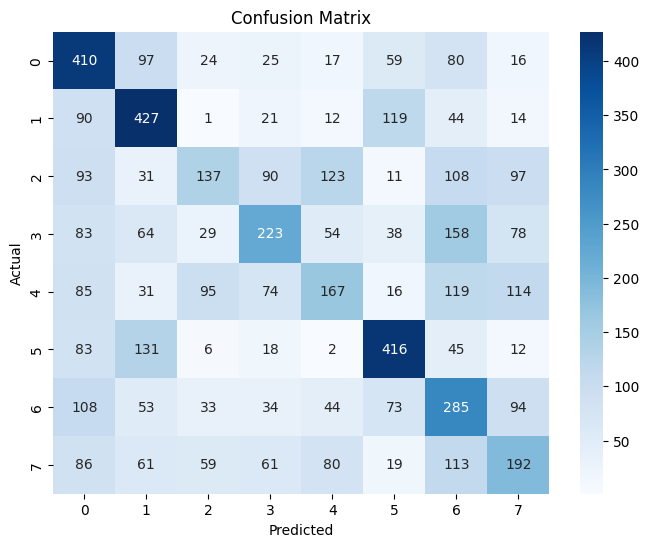

In [ ]:
# Implement a basic decision tree and see what our results are
# Create and train the decision tree model using DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(x2_train, y2_train)
# Predict the model on test set
y2_pred = model.predict(x2_test)

# Calculate accuracy
accuracy = accuracy_score(y2_test, y2_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("Classification Report:")
print(classification_report(y2_test, y2_pred))

cm = confusion_matrix(y2_test, y2_pred)
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Initial decision tree is alright, but not the best, we can improve upon it by using a random_forest_tree with specified hyperparameters
# Employ cross_validation to find optimal max_depth using a random_forest_classifier

# Define the hyperparameter grid
## NOTE: Google Colab will take a very long time if we were to train multiple hyperparameters altogether, so we did one after the other and kept
# an eye on whether our cross validation score would change or not. If it got better, we retained that particular hyperparameter setting
param_grid = {
    'n_estimators': [200],  # Number of trees
    'max_depth': [20],  # Tree depth
    'min_samples_split': [10],  # Minimum samples to split
    'min_samples_leaf': [5],  # Minimum samples per leaf
    'max_features': ['sqrt'],  # Number of features considered at each split
    'criterion': ['entropy'],  # Splitting criteria
    'bootstrap': [True]  # Whether to sample with replacement
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)
grid_search.fit(x2_train, y2_train)

# Get the results
results = pd.DataFrame(grid_search.cv_results_)

# Save the hyperparameters and their scores
columns_to_save = ['param_n_estimators', 'param_min_samples_split',
                   'param_min_samples_leaf', 'param_max_features', 'param_criterion',
                   'param_bootstrap', 'mean_test_score', 'std_test_score']
results[columns_to_save].sort_values(by='mean_test_score', ascending=False).to_csv("random_forest_results.csv", index=False)
# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best hyperparameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score: 0.39440983797727214


Random Forest Model Evaluation:
Accuracy: 0.4190425906370996
              precision    recall  f1-score   support

           0       0.41      0.59      0.49       728
           1       0.52      0.66      0.58       728
           2       0.35      0.18      0.24       690
           3       0.43      0.31      0.36       727
           4       0.33      0.22      0.27       701
           5       0.58      0.68      0.62       713
           6       0.31      0.39      0.34       724
           7       0.33      0.30      0.31       671

    accuracy                           0.42      5682
   macro avg       0.41      0.42      0.40      5682
weighted avg       0.41      0.42      0.40      5682



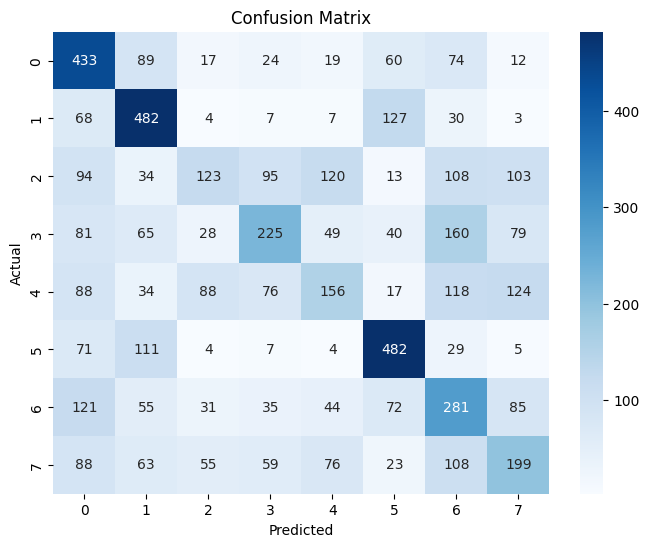

In [ ]:
# Create and train the random forest model based on the hyperparameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth = 20, min_samples_split=10, min_samples_leaf=5, max_features='sqrt', criterion='entropy', bootstrap = True, random_state=42)
rf_model.fit(x2_train, y2_train)

# Evaluate on the test set
y_rf_pred = rf_model.predict(x2_test)
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y2_test, y_rf_pred))
print(classification_report(y2_test, y_rf_pred))
cm = confusion_matrix(y2_test, y_rf_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()